In [ ]:
#Building GANs

In [ ]:
#importing libs and checking GPU
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable

from torch import Tensor
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

In [ ]:
import joblib

In [ ]:
torch.cuda.get_device_properties('cuda')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)

In [ ]:
!nvidia-smi

Fri May  5 05:35:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Model building

In [ ]:
#Defining basic model

#basic 3x3 conv block
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

#Definig Basic Block that downsamples and upsamles
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=False, upsample=False, nobn=False):
        super(BasicBlock, self).__init__()
        self.upsample = upsample
        self.downsample = downsample
        self.nobn = nobn
        if self.upsample:
            self.conv1 = nn.ConvTranspose2d(inplanes, planes, 4, 2, 1)
        else:
            self.conv1 = conv3x3(inplanes, planes, stride)
        if not self.nobn:
            self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        if self.downsample:
            self.conv2 =nn.Sequential(nn.AvgPool2d(2,2), conv3x3(planes, planes))
        else:
            self.conv2 = conv3x3(planes, planes)
        if not self.nobn:
            self.bn2 = nn.BatchNorm2d(planes)
        if inplanes != planes or self.upsample or self.downsample:
            if self.upsample:
                self.skip = nn.ConvTranspose2d(inplanes, planes, 4, 2, 1)
            elif self.downsample:
                self.skip = nn.Sequential(nn.AvgPool2d(2,2), nn.Conv2d(inplanes, planes, 1, 1))
            else:
                self.skip = nn.Conv2d(inplanes, planes, 1, 1, 0)
        else:
            self.skip = None
        self.stride = stride

    def forward(self, x):
        residual = x
        if not self.nobn:
            out = self.bn1(x)
            out = self.relu(out)
        else:
            out = self.relu(x)
        out = self.conv1(out)
        if not self.nobn:
            out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        if self.skip is not None:
            residual = self.skip(x)
        out += residual
        return out

In [ ]:
#Spectral normalization layer

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
#High2low model

class High2Low(nn.Module):
    def __init__(self):
        super(High2Low, self).__init__()
        blocks = [96, 96, 128, 128, 256, 256, 512, 512, 128, 128, 32, 32]

        self.noise_fc = nn.Linear(64, 4096)
        self.in_layer = nn.Conv2d(4, blocks[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.out_layer = nn.Sequential(
            nn.Conv2d(blocks[-1], 8, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

        downs = []
        in_feat = blocks[0]
        for i in range(8): # downsample layers
            b_down = not i % 2
            downs.append(BasicBlock(in_feat, blocks[i], downsample=b_down))
            in_feat = blocks[i]

        ups = []
        for i in range(2):
            ups.append(nn.PixelShuffle(2))
            ups.append(BasicBlock(blocks[8+i*2], blocks[8+i*2]))
            ups.append(BasicBlock(blocks[9+i*2], blocks[9+i*2]))

        self.down_layers = nn.Sequential(*downs)
        self.up_layers = nn.Sequential(*ups)

    def forward(self, x, z):
        noises = self.noise_fc(z)
        noises = noises.view(-1, 1, 64, 64)
        out = torch.cat((x, noises), 1)
        out = self.in_layer(out)
        out = self.down_layers(out)
        out = self.up_layers(out)
        out = self.out_layer(out)
        return out

#Discriminator
class BasicBlock_Discrim(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=False, nobn=False):
        super(BasicBlock_Discrim, self).__init__()
        self.downsample = downsample
        self.nobn = nobn

        self.conv1 = SpectralNorm(nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
        if not self.nobn:
            self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=False)
        if self.downsample:
            self.conv2 = nn.Sequential(nn.AvgPool2d(2, 2), SpectralNorm(nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)))
        else:
            self.conv2 = SpectralNorm(nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
        if not self.nobn:
            self.bn2 = nn.BatchNorm2d(planes)
        if inplanes != planes or self.downsample:
            if self.downsample:
                self.skip = nn.Sequential(nn.AvgPool2d(2, 2), SpectralNorm(nn.Conv2d(inplanes, planes, 1, 1)))
            else:
                self.skip = SpectralNorm(nn.Conv2d(inplanes, planes, 1, 1, 0))
        else:
            self.skip = None
        self.stride = stride

    def forward(self, x):
        residual = x
        if not self.nobn:
            out = self.bn1(x)
            out = self.relu(out)
        else:
            out = self.relu(x)
        out = self.conv1(out)
        if not self.nobn:
            out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        if self.skip is not None:
            residual = self.skip(x)
        out += residual
        return out

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        assert input_size in [16, 64]
        self.blocks = [128, 128, 256, 256, 512, 512]
        pool_start = len(self.blocks) - 4 if input_size == 64 else len(self.blocks) - 2
        self.out_layer = nn.Sequential(
            SpectralNorm(nn.Linear(16*self.blocks[-1], self.blocks[-1])),
            nn.ReLU(),
            SpectralNorm(nn.Linear(self.blocks[-1], 1))
        )

        rbs = []
        in_feat = 3
        for i in range(len(self.blocks)):
            b_down = bool(i >= pool_start)
            rbs.append(BasicBlock_Discrim(in_feat, self.blocks[i], downsample=b_down, nobn=True))
            in_feat = self.blocks[i]
        self.residual_blocks = nn.Sequential(*rbs)

    def forward(self, x):
        out = self.residual_blocks(x)
        out = out.view(-1, 16*self.blocks[-1])
        out = self.out_layer(out)
        return out


# low 2 high model
class GEN_DEEP(nn.Module):
    def __init__(self, ngpu=1):
        super(GEN_DEEP, self).__init__()
        self.ngpu = ngpu
        res_units = [256, 128, 96]
        inp_res_units = [
            [256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
             256], [256, 128, 128], [128, 96, 96]]

        self.layers_set = []
        self.layers_set_up = []
        self.layers_set_final = nn.ModuleList()
        self.layers_set_final_up = nn.ModuleList()

        self.a1 = nn.Sequential(nn.Conv2d(256, 128, 1, 1))
        self.a2 = nn.Sequential(nn.Conv2d(128, 96, 1, 1))

        self.layers_in = conv3x3(3, 256)

        layers = []
        for ru in range(len(res_units) - 1):
            nunits = res_units[ru]
            curr_inp_resu = inp_res_units[ru]
            self.layers_set.insert(ru, [])
            self.layers_set_up.insert(ru, [])

            if ru == 0:
                num_blocks_level = 12
            else:
                num_blocks_level = 3

            for j in range(num_blocks_level):
                # if curr_inp_resu[j]==3:
                self.layers_set[ru].append(BasicBlock(curr_inp_resu[j], nunits))
                # else:
                # layers.append(MyBlock(curr_inp_resu[j], nunits))

            self.layers_set_up[ru].append(nn.Upsample(scale_factor=2, mode='bilinear',align_corners=True))

            self.layers_set_up[ru].append(nn.BatchNorm2d(nunits))
            self.layers_set_up[ru].append(nn.ReLU(True))
            self.layers_set_up[ru].append(nn.ConvTranspose2d(nunits, nunits, kernel_size=1, stride=1))
            self.layers_set_final.append(nn.Sequential(*self.layers_set[ru]))
            self.layers_set_final_up.append(nn.Sequential(*self.layers_set_up[ru]))

        nunits = res_units[-1]
        layers.append(conv3x3(inp_res_units[-1][0], nunits))
        layers.append(nn.ReLU(True))

        layers.append(nn.Conv2d(inp_res_units[-1][1], nunits, kernel_size=1, stride=1))
        layers.append(nn.ReLU(True))

        layers.append(nn.Conv2d(nunits, 3, kernel_size=1, stride=1))
        layers.append(nn.Tanh())

        self.main = nn.Sequential(*layers)

    def forward(self, input):
        x = self.layers_in(input)
        for ru in range(len(self.layers_set_final)):
            if ru == 0:
                temp = self.layers_set_final[ru](x)
                x = x + temp
            elif ru == 1:
                temp = self.layers_set_final[ru](x)
                temp2 = self.a1(x)
                x = temp + temp2
            elif ru == 2:
                temp = self.layers_set_final[ru](x)
                temp2 = self.a2(x)
                x = temp + temp2
            x = self.layers_set_final_up[ru](x)

        x = self.main(x)

        return x

# testing model

In [ ]:
import matplotlib.pyplot as plt

Y shape from Gen torch.Size([1, 3, 16, 16])
output from dis tensor([[0.0380]], device='cuda:0', grad_fn=<AddmmBackward0>)
Y shape from Dis torch.Size([1, 1])
finished.


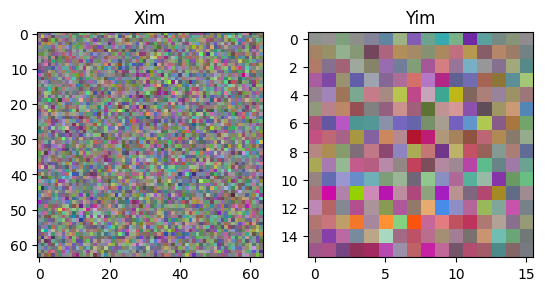

In [ ]:
#testing Generator and discriminator

def discriminator_test(in_size):
    # 16, 64 input_size
    net = Discriminator(in_size).cuda()
    X = np.random.randn(1, 3, in_size, in_size).astype(np.float32)
    X = torch.from_numpy(X).cuda()
    Y = net(X)
    print('output from dis',Y)
    print('Y shape from Dis',Y.shape)

def high2low_test():
    net = High2Low().cuda()
    Z = np.random.randn(1, 1, 64).astype(np.float32)
    X = np.random.randn(1, 3, 64, 64).astype(np.float32)
    Z = torch.from_numpy(Z).cuda()
    X = torch.from_numpy(X).cuda()
    Y = net(X, Z)
    print('Y shape from Gen',Y.shape)
    Xim = X.cpu().numpy().squeeze().transpose(1, 2, 0)
    Yim = Y.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    Xim = (Xim - Xim.min()) / (Xim.max() - Xim.min())
    Yim = (Yim - Yim.min()) / (Yim.max() - Yim.min())
    plt.subplot(1,2,1)
    plt.imshow(Xim)
    plt.title('Xim')

    plt.subplot(1,2,2)
    plt.imshow(Yim)
    plt.title('Yim')
#testing
high2low_test()
discriminator_test(16)
print("finished.")

torch.Size([1, 3, 64, 64])
output from dis tensor([[-0.0794]], device='cuda:0', grad_fn=<AddmmBackward0>)
Y shape from Dis torch.Size([1, 1])


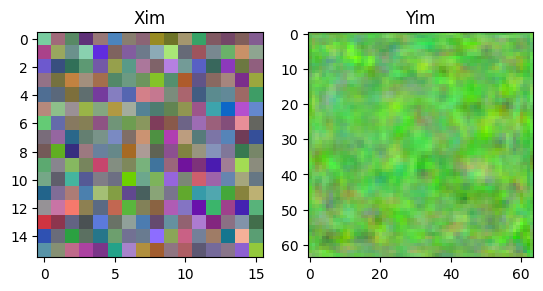

In [ ]:
def low2high_test():
    net = GEN_DEEP().cuda()
    X = np.random.randn(1, 3, 16, 16).astype(np.float32) # B, C, H, W
    X = torch.from_numpy(X).cuda()
    Y = net(X)
    print(Y.shape)

    Xim = X.cpu().numpy().squeeze().transpose(1,2,0)
    Yim = Y.detach().cpu().numpy().squeeze().transpose(1,2,0)
    Xim = (Xim - Xim.min()) / (Xim.max() - Xim.min())
    Yim = (Yim - Yim.min()) / (Yim.max() - Yim.min())

    plt.subplot(1,2,1)
    plt.imshow(Xim)
    plt.title('Xim')

    plt.subplot(1,2,2)
    plt.imshow(Yim)
    plt.title('Yim')

#testing
low2high_test()
discriminator_test(64)

# Data loader

In [ ]:
High_Data = ["/content/drive/MyDrive/sem4_p/Dataset/HIGH/celebs"]
Low_Data = ["/content/drive/MyDrive/sem4_p/Dataset/LOW/cctv_lr"]

class faces_data(Dataset):
    def __init__(self, data_hr, data_lr):
        self.hr_imgs = [os.path.join(d, i) for d in data_hr for i in os.listdir(d) if os.path.isfile(os.path.join(d, i))]
        self.lr_imgs = [os.path.join(d, i) for d in data_lr for i in os.listdir(d) if os.path.isfile(os.path.join(d, i))]
        self.lr_len = len(self.lr_imgs)
        self.lr_shuf = np.arange(self.lr_len)
        np.random.shuffle(self.lr_shuf)
        self.lr_idx = 0
        self.preproc = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.hr_imgs)

    def __getitem__(self, index):
        data = {}
        hr = cv2.imread(self.hr_imgs[index])
        lr = cv2.imread(self.lr_imgs[self.lr_shuf[self.lr_idx]])
        self.lr_idx += 1
        if self.lr_idx >= self.lr_len:
            self.lr_idx = 0
            np.random.shuffle(self.lr_shuf)
        data["z"] = torch.randn(1, 64, dtype=torch.float32)
        data["lr"] = self.preproc(lr)
        data["hr"] = self.preproc(hr)
        data["hr_down"] = F.avg_pool2d(data["hr"], 4, 4)
        return data

    def get_noise(self, n):
        return torch.randn(n, 1, 64, dtype=torch.float32)

# Training loop

In [ ]:
model_save = "/content/drive/MyDrive/sem4_p/exp2_unpr_training/models_l2h"
losses_save = "/content/drive/MyDrive/sem4_p/exp2_unpr_training/losses_l2h"

In [ ]:
# setting variables

seed_num = 2020
np.random.seed(seed_num)
torch.manual_seed(seed_num)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

learn_rate = 1e-4
alpha, beta = 1, 0.05

G_h2l = High2Low().cuda()

G_l2h = GEN_DEEP().cuda()
D_l2h = Discriminator(64).cuda()
mse = nn.MSELoss()



optim_D_l2h = optim.Adam(filter(lambda p: p.requires_grad, D_l2h.parameters()), lr=learn_rate, betas=(0.0, 0.9))
optim_G_l2h = optim.Adam(G_l2h.parameters(), lr=learn_rate, betas=(0.0, 0.9))



In [ ]:
data = faces_data(High_Data, Low_Data)
loader = DataLoader(dataset=data, batch_size=32, shuffle=True)

# Model loading

In [ ]:
#loading G_h2l model for otg degrade image
g_h2l_path = '/content/drive/MyDrive/sem4_p/exp2_unpr_training/models_h2l/model_epoch_800.pth'
g_h2l_checkpoint = torch.load(g_h2l_path)
G_h2l.load_state_dict(g_h2l_checkpoint['G_h2l'])

print(f"G_h2l model trained for {g_h2l_checkpoint['epoch']} loaded")

G_h2l model trained for 800 loaded


In [ ]:
#loading G and D for resume training
PATH ='/content/drive/MyDrive/sem4_p/exp2_unpr_training/models_l2h/model_epoch_300.pth'
checkpoint = torch.load(PATH)
G_l2h.load_state_dict(checkpoint['G_l2h'])
D_l2h.load_state_dict(checkpoint['D_l2h'])
optim_G_l2h.load_state_dict(checkpoint['optim_G_l2h'])
optim_D_l2h.load_state_dict(checkpoint['optim_D_l2h'])
start_epoch = checkpoint['epoch']

# Resume training

In [ ]:
#run this cell only after loading to keep record of epochs
start_epoch = start_epoch + 1 # last epoch of last training
max_epoch = start_epoch + 100 # give max epoch according to your resumed training epoch

print('start epoch after loading : ', start_epoch)
print('max epoch : ',max_epoch)

start epoch after loading :  301
max epoch :  401


In [ ]:
losses = joblib.load(f'/content/drive/MyDrive/sem4_p/exp2_unpr_training/losses_l2h/losses_at_{start_epoch-1}.pkl')

In [ ]:

l_D_l2h = 0

l_G_l2h = 0

In [ ]:
G_h2l.eval() # eval mode cuz we taking just inference here
print(f'Training epochs {start_epoch} to {max_epoch-1}')
for ep in range(start_epoch, max_epoch):

  G_l2h.train()
  D_l2h.train()

  for i, batch in enumerate(loader):


    optim_D_l2h.zero_grad()
    optim_G_l2h.zero_grad()

    zs = batch["z"].cuda()
    lrs = batch["lr"].cuda()
    hrs = batch["hr"].cuda()
    downs = batch["hr_down"].cuda()

    # generating otg lr
    lr_gen = G_h2l(hrs, zs)
    lr_gen_detach = lr_gen.detach()

    hr_gen = G_l2h(lr_gen_detach)
    hr_gen_detach = hr_gen.detach()

    # update discriminator
    loss_D_l2h = nn.ReLU()(1.0 - D_l2h(hrs)).mean() + nn.ReLU()(1 + D_l2h(hr_gen_detach)).mean()
    loss_D_l2h.backward()
    optim_D_l2h.step()

    # update generator
    optim_D_l2h.zero_grad()
    gan_loss_l2h = -D_l2h(hr_gen).mean()
    mse_loss_l2h = mse(hr_gen, hrs)

    loss_G_l2h = alpha * mse_loss_l2h + beta * gan_loss_l2h
    loss_G_l2h.backward()
    optim_G_l2h.step()

    l_D_l2h += round(loss_D_l2h.item(),5)
    l_G_l2h += round(loss_G_l2h.item(),5)

  print(f"\n ========{ep}========\n")

  print(f"({ep}) | D_l2h: {l_D_l2h/len(loader)}, G_l2h: {l_G_l2h/len(loader)} |")

  losses['l_D_l2h'].append(l_D_l2h/len(loader))
  losses['l_G_l2h'].append(l_G_l2h/len(loader))

  l_D_l2h = 0
  l_G_l2h = 0

  print(f"\n ========{ep+1}========\n")

  G_l2h.eval()
  D_l2h.eval()

  if ep % 50 == 0 :
    save_file = "{}/model_epoch_{}.pth".format(model_save, ep)

    # Saving state of both models and optimizers to resume training
    torch.save({"G_l2h": G_l2h.state_dict(), "D_l2h": D_l2h.state_dict(),
                "optim_G_l2h": optim_G_l2h.state_dict(), "optim_D_l2h": optim_D_l2h.state_dict(),
                'epoch': ep}, save_file)
    joblib.dump(losses,losses_save+f'/losses_at_{ep}.pkl')
    print('saved at ',ep)

print('finished loop!!')

Training epochs 301 to 400

 ========301========

(301) | D_l2h: 0.4083995238095238, G_l2h: 0.12826841269841266 |

 ========302========


 ========302========

(302) | D_l2h: 0.4232830158730158, G_l2h: 0.1282979365079365 |

 ========303========


 ========303========

(303) | D_l2h: 0.41583698412698405, G_l2h: 0.12724015873015873 |

 ========304========


 ========304========

(304) | D_l2h: 0.446754761904762, G_l2h: 0.12715555555555552 |

 ========305========


 ========305========

(305) | D_l2h: 0.45228809523809516, G_l2h: 0.12694920634920634 |

 ========306========


 ========306========

(306) | D_l2h: 0.4372574603174604, G_l2h: 0.12699984126984123 |

 ========307========


 ========307========

(307) | D_l2h: 0.4790446031746032, G_l2h: 0.12534428571428569 |

 ========308========


 ========308========

(308) | D_l2h: 0.43939190476190465, G_l2h: 0.12585365079365077 |

 ========309========


 ========309========

(309) | D_l2h: 0.4617879365079364, G_l2h: 0.1258425396825397 |

 ====

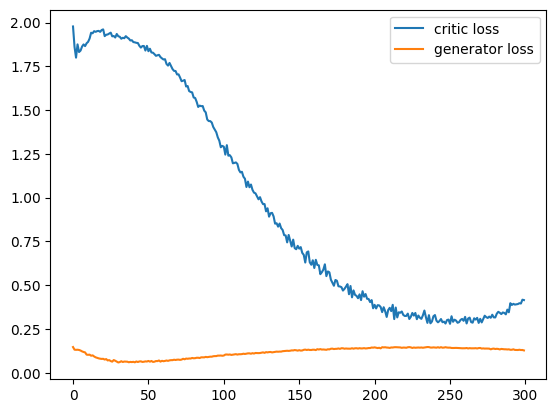

In [ ]:
def print_losses():
  plt.plot(losses['l_D_l2h'])
  plt.plot(losses['l_G_l2h'])
  plt.legend(['critic loss', 'generator loss'])
  plt.show()

print_losses()

In [ ]:
def inference_test(in_img,model_epoch=0):

    in_img = cv2.resize(in_img,(64,64),cv2.INTER_AREA)
    preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    in_img = preprocess(in_img)
    in_img = in_img.view(1,3,64,64)
    in_img = in_img.cuda()
    Z = torch.randn(1,1, 64, dtype=torch.float32).cuda()

    # inference on low to high
    G_h2l.eval()
    G_l2h.eval()

    g_lr = G_h2l(in_img,Z)
    g_lr_detach = g_lr.detach()

    g_hr = G_l2h(g_lr_detach)

    np_low_gen = g_lr_detach.cpu().numpy().squeeze().transpose(1,2,0)
    np_low_gen = (np_low_gen - np_low_gen.min()) / (np_low_gen.max() - np_low_gen.min())
    np_low_gen = (np_low_gen * 255).astype(np.uint8)
    np_low_gen = cv2.cvtColor(np_low_gen,cv2.COLOR_BGR2RGB)


    np_high_gen = g_hr.detach().cpu().numpy().squeeze().transpose(1,2,0)
    np_high_gen = (np_high_gen - np_high_gen.min()) / (np_high_gen.max() - np_high_gen.min())
    np_high_gen = (np_high_gen * 255).astype(np.uint8)
    np_high_gen = cv2.cvtColor(np_high_gen,cv2.COLOR_BGR2RGB)

    np_in_img = in_img.cpu().numpy().squeeze().transpose(1,2,0)
    np_in_img = (np_in_img - np_in_img.min()) / (np_in_img.max() - np_in_img.min())
    np_in_img = (np_in_img * 255).astype(np.uint8)
    np_in_img = cv2.cvtColor(np_in_img,cv2.COLOR_BGR2RGB)

    plt.subplot(1,3,1)
    plt.imshow(np_in_img)
    plt.title('Input (HR)')

    plt.subplot(1,3,2)
    plt.imshow(np_low_gen)
    plt.title('Generated (LR)')

    plt.subplot(1,3,3)
    plt.imshow(np_high_gen)
    plt.title('Generated (LR -> HR)')

    #cv2.imwrite(f'/content/drive/MyDrive/sem4_p/exp2_unpr_training/inference/l2h_at_ep{model_epoch}.png',np_high_gen)


In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/Dataset/HIGH/celebs/000001.jpg')

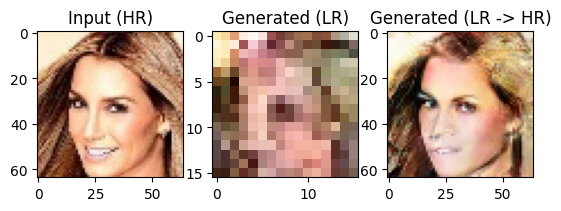

In [ ]:
inference_test(t_img,300)

In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/Dataset/HIGH/celebs/000396.jpg')

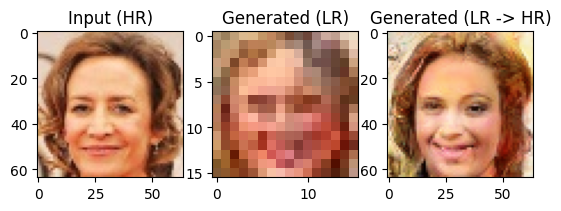

In [ ]:
inference_test(t_img,300)

In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/Dataset/HIGH/celebs/000023.jpg')

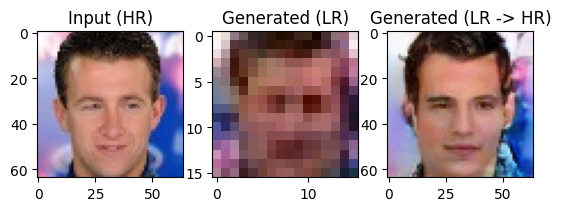

In [ ]:
inference_test(t_img,300)

In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/test_data/00015.png')

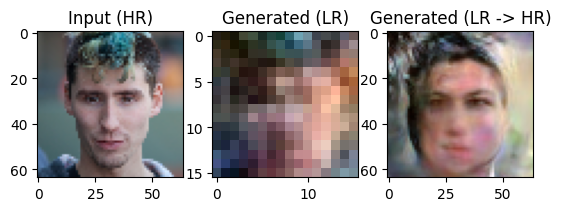

In [ ]:
inference_test(t_img,300)

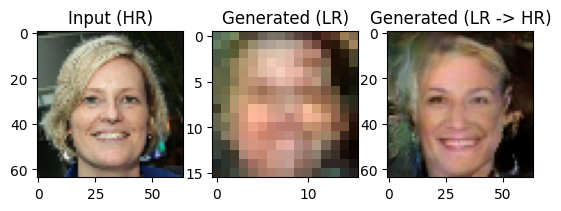

In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/test_data/00018.png')
inference_test(t_img,300)

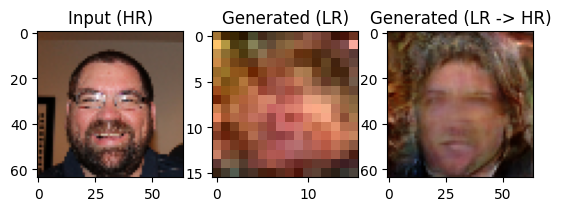

In [ ]:
t_img = cv2.imread('/content/drive/MyDrive/sem4_p/test_data/00023.png')
inference_test(t_img,300)